<p style="text-align:center">
<h1 align="center">Interpretable machine learning</h1>
<h2 align="center">Vine</h2>
</p>


<p style="text-align:center">
   Thomas Bury<br>
   Pretending to be a DS<br>
</p>

<div align="center">
    <img class="fblogo" border="0" src="bender_hex.png" width="100px" align="center" />
</div>


# Coins, apples and bias

<p float="left">
  <img src="coin.jpg" width="400" />
</p>

$ \mathrm{P}[\mathrm{Head}] = \cdots $

0.5, obviously. But what about him?
<p float="left">
  <img src="newton.jpg" width="100" />
</p>

Is the coin not a solid body? Is it not supposed to be ruled by Newton's laws and therefore the movement be deterministic? We are so used to it that we don't even consider the question "is it really probabilistic?" -> Example of misinterpretation and thought-bias

[The three-dimensional dynamics of the die throw](http://kapitaniak.kdm.p.lodz.pl/papers/2012/Kapitaniak_Strzalko_Grabski_Kapitaniak.pdf)

Are human beings rational? 

 - [Rationality definition](https://en.wikipedia.org/wiki/Rationality)
 - [Randomness human behaviour](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005408)

# Explainability vs Interpretability

 * Interpretability: *predict* what would happen if you changed the input (i.e. predictions).
 * Explainability: explain why this change happens, the internal mechanics (models that can summarize the reasons for specific behaviour)
 
If you can explain it, you can interpret it. The converse is not true.

However, interpretability is often not understood as such. Causation and correlation are often confused.

# Explainability vs Interpretability cont'd

Example: throwing a ball with an initial speed $\vec{v}_{0}$, you observe it lands at $\vec{r}_{0}$. You change the speed from $\vec{v}_{0}$ to $\vec{v}_{1}$, same direction
 - **Interpretation**: the ball will land farther, using historical data you predict the landing to occur at $\vec{r}_{0}$ (you collected data by making an experiment and made a regression and thus derive a phenomenological/empirical model)
 - **Explanation**: the ball trajectory obeys Newton's laws. You know the exact effect of initial position and speed on the trajectory

# Is interpretability a myth or useful?
 - What if many features ($10$, $100$, $10^{6}$), correlated and predictive power spread among them? Will you be able to summarize them with a *verbal template*?  
 - What if two very different models (GLM and GBM for instance) predict the same values but interpretations differ? Is the interpretation useful at all?
 - What if you can interpret the model? Does it give you more insight on the causal relationship than you do not know? (and correlation doesn't mean causation)
 - Machine learning and inference are iterative by nature, so is the interpretation
 - Does the interpretation change if you include new information that actually truly matters? If yes can we rely on the interpretation?
 - Do you consider your decision making as interpretable? Are you a rational being? (I'm far from being rational even if I'm more a robot than a human being according to my friends)
 - Etc, see for instance this [vlog](https://zoom.us/recording/play/0y-iI9HamgyDzzP2k_jiTu6jB7JgVVXnjWZKDMbnyRTn3FsxTDZy6Wkrj3_ekx4J?startTime=1538497702000), fast forward to 20' and this [paper](https://arxiv.org/pdf/1606.03490.pdf) for instance
 
 
<h3 align="center">All is about being critical. Correlation is not causation. Interpretation is not as valuable as one might think at first glance if the purpose is not well defined beforehand (for marketing? for regulation? for common knowledge? for being reassured)</h3>


# So what?

Even if we care about the predicted values and not the structure of the data generation process, it's however useful to know how the response is *correlated* to the predictors/information we know.  

But keep in mind that...

<p float="left">
  <img src="corrcause.png" width="400" />
  <img src="corrcause2.png" width="400" />
</p>

<!-- <p float="left">
  <img src="cc.jpg" width="300" />
  <img src="cc3.png" width="300" />
</p> -->
<!-- <p float="left">
  <img src="correlation.png" width="600" />
</p> -->
<!-- <p float="left">
  <img src="ccmarry.gif" width="600" />
</p> -->

However, if we have a *theory* (natural sciences) or enough observed *stylized facts* (finance):
<p float="left">
  <img src="cause.jpg" width="600" />
</p>

Especially important when communicating with management and marketing

<p float="left">
  <img src="moustache.jpg" width="600" />
</p>

What is causal for a model $y = f(\mathbf{X})$ might just be a correlation in real-world because of an exogenous latent (not directly observed) variable

# A simple artificial example

<div align="left">
    <img border="0" src="pf.jpg" width="400px"  align="center" />
</div>

In [1]:
# linear algebra, random number and so on
from scipy.linalg import cholesky
from scipy.stats import truncnorm
# DataFrame and arrays
import pandas as pd
import numpy as np
# Statistical models
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Explainers
import shap
from pycebox.ice import ice, ice_plot
# LightGBM
import lightgbm as lgb
from xbart import XBART
# Bayesian optimization
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
# Utilities
from sys import getsizeof, path
import importlib

path.append("C:\\Users\\xtbury\\Documents\\Projects\\ZoningBE\\modules")
import pricingnoglm.explain.vinelite as noglmvinelite

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
from notebook.services.config import ConfigManager
cm = ConfigManager()
cm.update('livereveal', {
              'width': 1920,
              'height': 1080,
})

{'width': 1920, 'height': 1080}

In [3]:
# fix the seed for reproducibility
np.random.seed(1915)

# Correlation matrix
corr_mat= np.array([[1.0, -0.4, -0.9],
                    [-0.4, 1.0, 0.0],
                    [-0.9, 0.0, 1.0]])
n_samp = 1000

# Compute the (upper) Cholesky decomposition matrix
upper_chol = cholesky(corr_mat)
rnd = np.random.normal(0.0, 1.0, size=(n_samp, 3))
corr_data = rnd @ upper_chol 

# Add categorical var
cat_rnd = 2 * np.random.randint(2, size=n_samp) - 1
corr_data = np.column_stack((corr_data, cat_rnd))

# Add noise
corr_data = np.column_stack((corr_data, np.random.normal(0.0, 1.0, size=(n_samp, 1))))

# Dataframe
corr_data = pd.DataFrame(corr_data)
corr_data.columns = ['x_1', 'x_2', 'x_3', 'x_4', 'noise']
corr_data['set'] = 'train'
corr_data.loc[np.round(n_samp/2).astype(int):n_samp, 'set'] = 'test'

# Response
beta_0, beta_1, beta_24, beta_3= 4, 7, -6, 5
corr_data['y'] = beta_0 + beta_1 * corr_data['x_1'] + beta_24 * corr_data['x_2'] * corr_data['x_4'] + beta_3 * corr_data['x_3'] + corr_data['noise'] #+ beta_2 * corr_data['x2'] 

## The Dummy model




\begin{align}
  y& = \beta_{0} + \beta_{1} x_{1} + \beta_{24} x_{2}x_{4} + \beta_{3}x_{3} + \epsilon \\
  \\
  \beta_0 &= 4\\
  \beta_1 &= 7\\
  \beta_{24} &= -6\\
  \beta_3 &= 5\\
  \epsilon &\sim \mathcal{N}(0,1)\\
  \mathrm{corr}(X) &= \begin{bmatrix}
1.0 & -0.4 & -0.9\\
-0.4 & 1.0 & 0.0 \\
-0.9 & 0.0 & 1.0
\end{bmatrix}
\end{align}

with correlated predictors (common case)

In [4]:
np.round(np.corrcoef(corr_data[ ['y', 'x_1', 'x_2', 'x_3', 'noise']].T), 2)

array([[ 1.  ,  0.38, -0.45, -0.19,  0.12],
       [ 0.38,  1.  , -0.43, -0.9 ,  0.02],
       [-0.45, -0.43,  1.  ,  0.05,  0.  ],
       [-0.19, -0.9 ,  0.05,  1.  , -0.03],
       [ 0.12,  0.02,  0.  , -0.03,  1.  ]])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


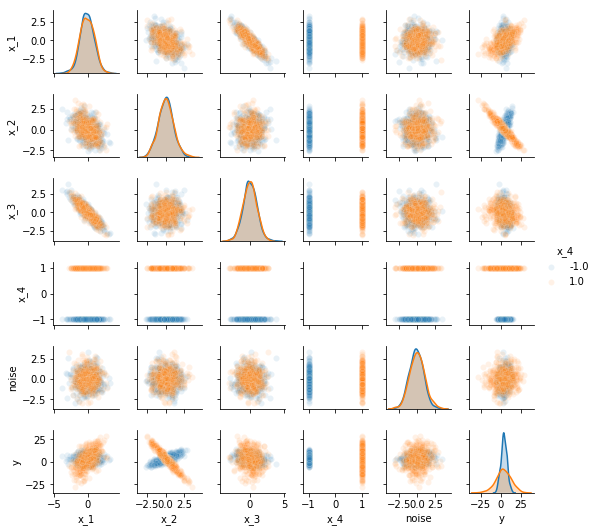

In [31]:
sns.pairplot(corr_data, hue="x_4", plot_kws={'alpha': 0.1}, height=1.25)
plt.show()

From the pairplot, we deduce that there is an interaction between $x_{2}$ and $x_{4}$. Let's see what happens when we do not include all the relevant predictors and what are the consequences of collinearity on the coefficients and the model interpretation.

## Collinearity and the variance inflation factor

Collinearity increases the variance of estimator and inflates the t-stat. 
Moreover, correlation can induce significantly different interpretation than the reality if we don't know exactly the data generation process (the majority of cases). 
Compare the regression coefficient values to the true values and have a look at their confidence interval.

Be careful

In [6]:
# Variance Inflation Factor
#
train = corr_data[corr_data.set=='train']
test = corr_data[corr_data.set=='test']
y = train['y']
X = train[['x_1', 'x_2', 'x_3', 'x_4']]

print(pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns))

x_1    37.589518
x_2     7.241415
x_3    30.426052
x_4     1.001271
dtype: float64


VIF are large. We must pay attention to the results and not consider the coefficients as independent from each other.

In [7]:
y = train['y']
X = train[['x_3']]

X = sm.add_constant(X)
ols_dummy = sm.OLS(y, X).fit()
print(ols_dummy.summary())

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     13.40
Date:                Fri, 27 Sep 2019   Prob (F-statistic):           0.000278
Time:                        11:45:32   Log-Likelihood:                -1667.2
No. Observations:                 500   AIC:                             3338.
Df Residuals:                     498   BIC:                             3347.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6906      0.304     12.120      0.0

The estimation is $\hat{\beta}_{3} = -1.12 \pm 0.30$. However the true value is $\beta_{3}=5$. Predicted values are grossly in line with observations and the coefficient has the wrong is negative instead of being positive.
In this case, the interpretation will be wrong even if it predicted values are indeed decreasing with $x_{3}$.

In [8]:
def add_identity(axes, *line_args, **line_kwargs):
    identity, = axes.plot([], [], *line_args, **line_kwargs)
    def callback(axes):
        low_x, high_x = axes.get_xlim()
        low_y, high_y = axes.get_ylim()
        low = max(low_x, low_y)
        high = min(high_x, high_y)
        identity.set_data([low, high], [low, high])
    callback(axes)
    axes.callbacks.connect('xlim_changed', callback)
    axes.callbacks.connect('ylim_changed', callback)
    return axes

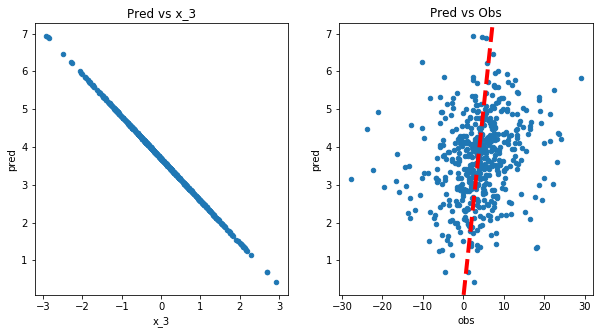

In [9]:
pred = ols_dummy.predict(sm.add_constant(test[['x_3']]))
pred_df = test.loc[:, ['x_3']]
pred_df['pred'] = pred.values
pred_df['obs'] = test.y.values
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2)
pred_df.plot(kind='scatter', x='x_3', y='pred', ax=ax1, title="Pred vs x_3", figsize=(10,5))
pred_df.plot(kind='scatter', x='obs', y='pred', ax=ax2, title="Pred vs Obs")
add_identity(ax2, color='r', ls='--', linewidth=4)
plt.show(fig)

In [10]:
# Using more predictors
y = train['y']
X = train[['x_1', 'x_2', 'x_3']]

print(pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns))

X = sm.add_constant(X)
ols_wo_int = sm.OLS(y, X).fit()
print(ols_wo_int.summary())

x_1    37.573071
x_2     7.240498
x_3    30.408380
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     36.36
Date:                Fri, 27 Sep 2019   Prob (F-statistic):           2.98e-21
Time:                        11:45:33   Log-Likelihood:                -1624.1
No. Observations:                 500   AIC:                             3256.
Df Residuals:                     496   BIC:                             3273.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

 - $\hat{\beta}_{1} = 7.2 \pm 1.7$, close to the true value $7$ but the confidence interval is huge. 
 - $\hat{\beta}_{2}$ is not zero, might be misleading. However the t-stat is large and the truth is that $x_{2}$ has not direct effect on the response.
 - $\hat{\beta}_{3} = 5.5 \pm 1.5$ close to the true value $5$ but the confidence interval is huge. 

Including more information improves the quality of the interpretation, this conlcusion is made only because we know the true data generation process. However we cannot 

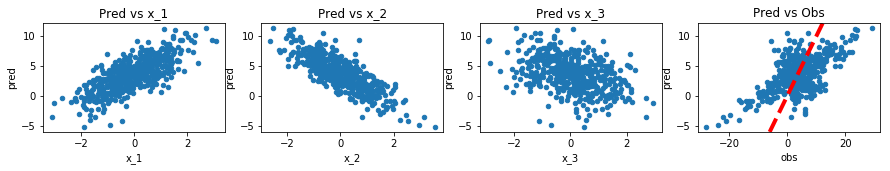

In [11]:
pred = ols_wo_int.predict(sm.add_constant(test[['x_1', 'x_2', 'x_3']]))
pred_df = test.loc[:, ['x_1', 'x_2', 'x_3']]
pred_df['pred'] = pred.values
pred_df['obs'] = test.y.values
# Plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
pred_df.plot(kind='scatter', x='x_1', y='pred', ax=ax1, title="Pred vs x_1", figsize=(15,2))
pred_df.plot(kind='scatter', x='x_2', y='pred', ax=ax2, title="Pred vs x_2")
pred_df.plot(kind='scatter', x='x_3', y='pred', ax=ax3, title="Pred vs x_3")
pred_df.plot(kind='scatter', x='obs', y='pred', ax=ax4, title="Pred vs Obs")
add_identity(ax4, color='r', ls='--', linewidth=4)
plt.show(fig)

In [12]:
# We are lucky, we have all the relevant predictors and we know what is the exact DGP
# Using the pairplot, we can therefore build an even better model
y, X = patsy.dmatrices('y ~ x_1 + x_2 * x_4 + x_3', train)
full_ols = sm.OLS(y, X).fit()
print(full_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     4665.
Date:                Fri, 27 Sep 2019   Prob (F-statistic):               0.00
Time:                        11:45:33   Log-Likelihood:                -704.91
No. Observations:                 500   AIC:                             1422.
Df Residuals:                     494   BIC:                             1447.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.9572      0.045     88.456      0.0

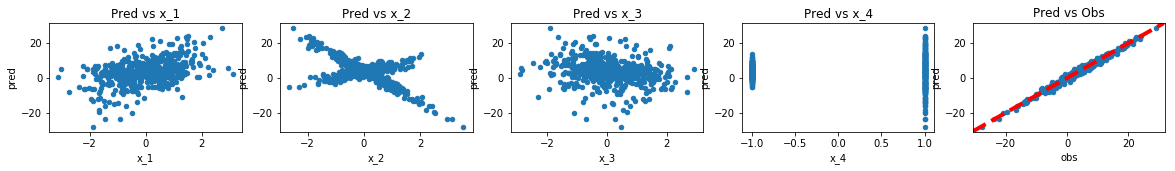

In [13]:
# Full example
y, X = patsy.dmatrices('y ~ x_1 + x_2 * x_4 + x_3', test)
pred = full_ols.predict(X)
pred_df = pd.DataFrame(X)
pred_df.columns = ["Intercept", "x_1", "x_2", "x_4", "x_2:x_4", "x_3"]
pred_df['pred'] = pred
pred_df['obs'] = test.y.values
# Plot
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5)
pred_df.plot(kind='scatter', x='x_1', y='pred', ax=ax1, title="Pred vs x_1", figsize=(20,2))
pred_df.plot(kind='scatter', x='x_2', y='pred', ax=ax2, title="Pred vs x_2")
pred_df.plot(kind='scatter', x='x_3', y='pred', ax=ax3, title="Pred vs x_3")
pred_df.plot(kind='scatter', x='x_4', y='pred', ax=ax4, title="Pred vs x_4")
pred_df.plot(kind='scatter', x='obs', y='pred', ax=ax5, title="Pred vs Obs")
add_identity(ax5, color='r', ls='--', linewidth=4)
plt.show(fig)

In the last model, everything is right. We used the exact functional form for the regression which means that we knew the DGP beforehand (as we know Newton's law before performing a ballistic experiment). We can in this particular case *explain* the regression model. Note it's far to be frequent.

# Unknown data generating process (DGP), non-linear models and models interpretation

Most of the time, we don't have a clue of what is the DGP and we often use a non-linear model. We want at least to know how the response is *correlated* to the set of predictors we have.
For that, we use interpretable models (meta-models on top of the actual one or importance attribution). 

NB: we don't have *full information* (here meaning, we might lack significant predictors). This and the lack of knowledge about the DGP is why we cannot conclude anything from the correlation between the response and the predictors.

## LightGBM as an example

Pretend that we don't know anything about the DGP and fit a *naive* GBM (I'll use lightGBM flavour, the tastier for now with Catboost for those who like kittens)

<div align="left">
    <img border="0" src="light.png" width="250px"  align="center" />
</div>

Side note: roughly an interaction is when the slope is modulated by other predictor(s)

In [14]:
# Naive lightGBM without optimization
y = train['y']
X = train[['x_1', 'x_2', 'x_3', 'x_4']]
regr = lgb.LGBMRegressor()
regr.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

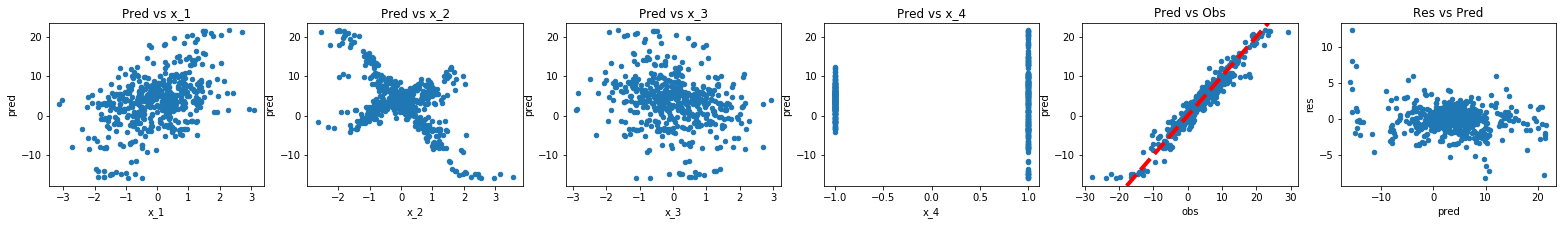

In [15]:
y = test['y']
X = test.loc[:, ['x_1', 'x_2', 'x_3', 'x_4']]
y_lgb = regr.predict(X)
#y_xbart = xbart.predict(X)
pred_df = X.copy()
pred_df['pred'] = y_lgb #y_xbart #
pred_df['obs'] = test.y.values
pred_df['res'] = pred_df['pred'] - pred_df['obs']
# Plot
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6)
pred_df.plot(kind='scatter', x='x_1', y='pred', ax=ax1, title="Pred vs x_1", figsize=(27,3))
pred_df.plot(kind='scatter', x='x_2', y='pred', ax=ax2, title="Pred vs x_2")
pred_df.plot(kind='scatter', x='x_3', y='pred', ax=ax3, title="Pred vs x_3")
pred_df.plot(kind='scatter', x='x_4', y='pred', ax=ax4, title="Pred vs x_4")
pred_df.plot(kind='scatter', x='obs', y='pred', ax=ax5, title="Pred vs Obs")
add_identity(ax5, color='r', ls='--', linewidth=4)
pred_df.plot(kind='scatter', x='pred', y='res', ax=ax6, title="Res vs Pred")
plt.show(fig)

Let's explain this lightGBM model (note that exact results exist in the litterature for tree based ensemble models)

# ICE and PDP plots

<div align="left">
    <img border="0" src="ice.jpg" width="100px"  align="center" />
</div>

 * ICE (Individual Conditional Expectation) plots display one line per instance that shows how the instance’s prediction changes when a feature changes. So ICE plots are local interpretation, meaning at the row/policy level.
 * The PDP (The partial dependence plot) is the average effect (average of ICE curves) of a feature and therefore is a global (at portfolio/dataset level) interpretation.

If you want more details, [here is a great e-book](https://christophm.github.io/interpretable-ml-book/)

 - The PDP limited to 2D visualisation, might not render interactions, assumes independence of the predictors, as it averages the individual effect it does not render heterogeneity
 - The ICE cannot be surface plotted meaningfully, quickly overplotting when many rows in the data set (eventually, the plot will just be filled in with curves)

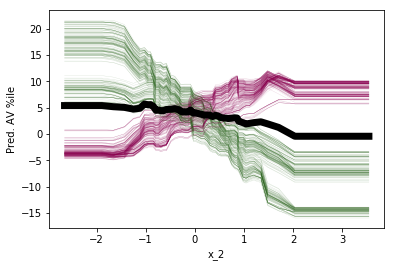

In [16]:
# purple and green light lines are the ICE curves, the black bold one is the PDP
# We can observe the lightGBM detects well the non-linearities in the test set
ice_df = ice(X, 'x_2', regr.predict, num_grid_points=50)
ice_plot(ice_df, alpha=.2, linewidth=0.3, plot_pdp=True, color_by='x_4', pdp_kwargs={'c': 'k', 'linewidth': 7}, cmap='PiYG')
plt.ylabel('Pred. AV %ile')
plt.xlabel('x_2');

 - Bold black line: PDP, similar to the curve returned by Emblem. It cannont detect interactions.
 - Light lines: ICE curves, render heterogeneity and interaction but quickly *overplot* if many observations

For a more complete discussion see [Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/agnostic.html)

# VINE (Visual INteraction Effects)

[A new method](https://arxiv.org/abs/1904.00561), brefly: it smartly consists in clustering ICE curves to avoid overplotting and provides a mesoscale interpretation (between local/row/policy and global/dataset/portfolio levels). Limited to tabular data (not suited to text or images).

In [17]:
vine_dic=noglmvinelite.export(X, y, regr.predict, num_clusters=2, num_grid_points=50)



--------------------------------------------------
passed time vine for 500 rows:      1.25 s (   0.02 min, 0.00 h)


No handles with labels found to put in legend.


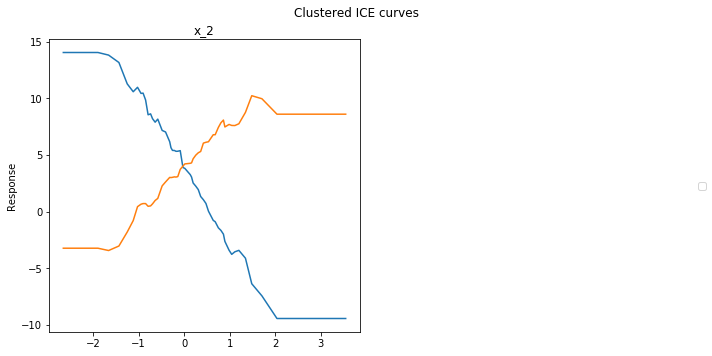

In [18]:
df = noglmvinelite.get_df_vine(vine_dic=vine_dic, features=['x_1', 'x_2', 'x_3', 'x_4'])
vine_df = noglmvinelite.get_df_vine(vine_dic, ['x_2'])
noglmvinelite.plot_vine(vine_dic, ['x_2'], ax_ylabel='Response', log_scale=False, nrows=1, ncols=2, figsize=(10, 5))

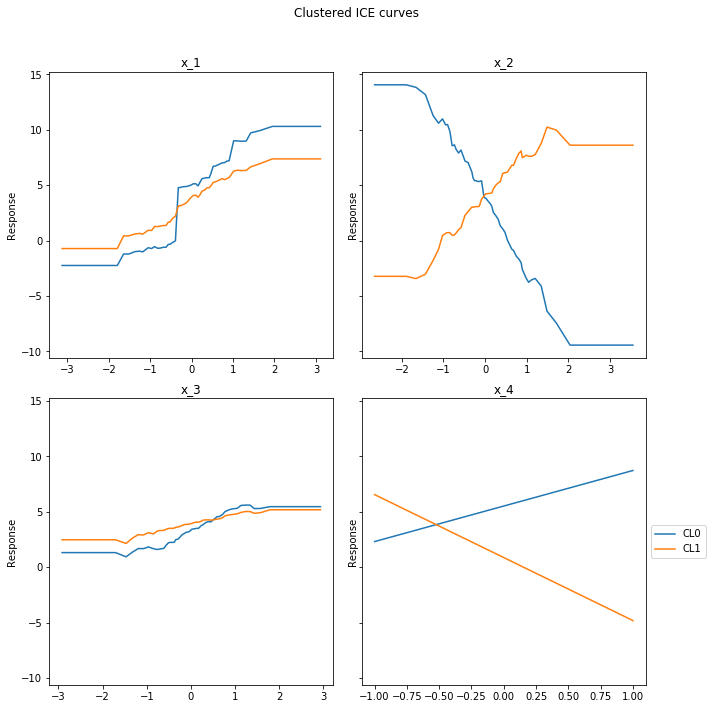

In [19]:
noglmvinelite.plot_vine(vine_dic, ['x_1', 'x_2', 'x_3', 'x_4'], ax_ylabel='Response', log_scale=False, nrows=2, ncols=2, figsize=(10, 10))

In the last figure, left panels, the curves are parellel. We can conclue that no interaction terms are involved. Moreover if we chose a different number of clusters (4, for instance) we would have as output:



--------------------------------------------------
passed time vine for 500 rows:      1.33 s (   0.02 min, 0.00 h)


No handles with labels found to put in legend.


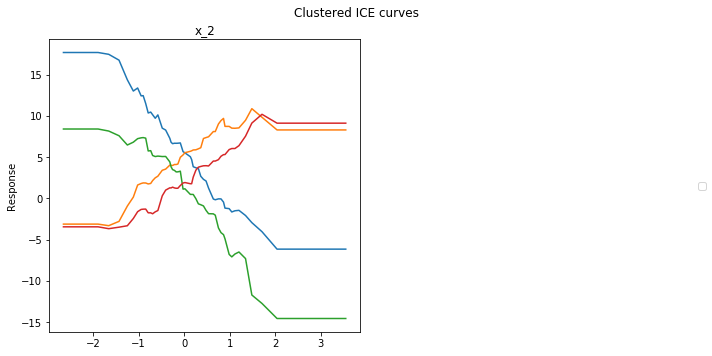

In [20]:
vine_dic=noglmvinelite.export(X, y, regr.predict, num_clusters=4, num_grid_points=50)
df = noglmvinelite.get_df_vine(vine_dic=vine_dic, features=['x_1', 'x_2', 'x_3', 'x_4'])
vine_df = noglmvinelite.get_df_vine(vine_dic, ['x_2'])
noglmvinelite.plot_vine(vine_dic, ['x_2'], ax_ylabel='Response', log_scale=False, nrows=1, ncols=2, figsize=(10, 5))

The parallel curves can be grouped together and we end up with only two clusters. There is a nicer way to group clusters but I'll let that aside for the interested reader (see the VINE paper)

# Shapley values

<div align="left">
    <img border="0" src="shapley.jpg" width="200px"  align="center" />
</div>

Old result of game theory (1953) which is the only possible consistent and locally accurate additive feature attribution method based on expectations.


**Shapley interpreter**, currently the golden interpreter. Provides both at the row (micro/local) and portfolio (macro/gloal) level explanations, explore interactions. It can be proven that the linear explainer built using Shapley values is the unique explainer, all the other linear explainers being a particular case of the SHAP one (see [this reference](https://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf) and [this reference](https://arxiv.org/pdf/1611.07478.pdf) ). 

## Technical blabla

The SHAP interpreter is a linear additive one build on rational axioms and take the form: $$ g(z) = \phi_{0}+\sum_{i=0}^{M}\phi_{i}z_{i}$$ where the $z_{i}$ are simplified (scaled) predictors, $\phi_{i}$ are the so-called Shapley values and $g(z)$ the model's prediction (minus the average). In the case of a simple linear model, the Shapley values $\phi_{i}$ are nothing but the regression coefficients. Observing only a single feature at a time implies that dependencies between features are not taken into account, which could produce inaccurate and misleading explanations of the model’s decision-making process. This is where cooperative game theory enters: feature values of an instance work together to cause a change in the model’s prediction with respect to the model’s expected output, and it divides this total change in prediction among the features in a way that is “fair” to their contributions across all possible subsets of features (see this [blog](https://towardsdatascience.com/understanding-how-ime-shapley-values-explains-predictions-d75c0fceca5a)). Note that as explained in the previous section, for tree-based models, there is an exact explainer which is much faster (and equivalent to) compute the Shapley values. See [Tree SHAP paper](https://arxiv.org/pdf/1802.03888.pdf)

In [21]:
def treeshapvalues(model, X_tt):
    # load JS visualization code to notebook
    shap.initjs()
    # build the explainer
    explainer = shap.TreeExplainer(model)  #
    shap_values = explainer.shap_values(X_tt)
    return explainer, shap_values

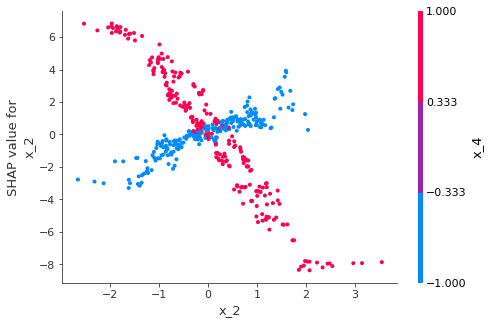

In [22]:
explainer, shap_values = treeshapvalues(regr, X)
shap.dependence_plot("x_2", shap_values, X) #, interaction_index="x_4")

The most relevant predictor for the interaction term is picked up automatically. This is a *global* interpretation (average effect over the whole data set). The Shapley interpreter is also able to interpret at the local scale (row/policy level) but it should not be generalized to the global/portfolio level. Indeed local and global interpretations might be in opposition. See next slide for an example.

In [23]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])


In [24]:
shap.force_plot(explainer.expected_value, shap_values[25,:], X.iloc[25,:])

The Shapley interpreter is versatile. It returns a summary plot and variable importance. For a complete review see the resources at the last slides.

In [25]:
def summaryplot(shap_values, X_tt):
    shap.summary_plot(shap_values, X_tt)
    shap.summary_plot(shap_values, X_tt, plot_type="bar")

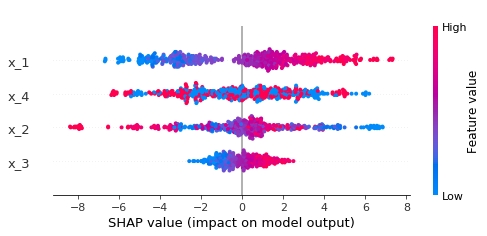

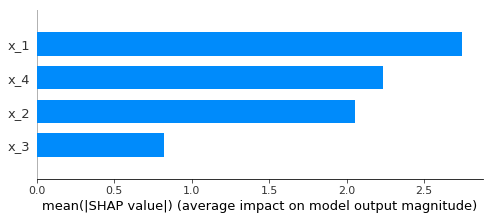

In [26]:
summaryplot(shap_values, X)

# Resources

 - [The Mythos of Model Interpretability](https://arxiv.org/pdf/1606.03490.pdf)
 - [Interpretable machine learning](https://christophm.github.io/interpretable-ml-book/)
 - [Peeking Inside the Black Box](https://arxiv.org/pdf/1309.6392.pdf)
 - [Shapley values](https://github.com/slundberg/shap)
 - [VINE](https://arxiv.org/pdf/1904.00561.pdf)
 - [R DALEX](http://uc-r.github.io/dalex)
 - [Video tutorial](https://www.youtube.com/watch?v=NxYCY8-Qfx0)

In [27]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
# corr_data.plot(kind='scatter', x='x1', y='y', title="Response vs Pred 1", ax=ax1, figsize=(8,2))
# corr_data.plot(kind='scatter', x='x2', y='y', title="Response vs Pred 2", ax=ax2, figsize=(8,2))
# corr_data.plot(kind='scatter', x='x3', y='y', title="response vs Pred 3", ax=ax3, figsize=(8,2))
# plt.show(fig)

In [28]:
# from scipy.linalg import cholesky
# from scipy.stats import truncnorm
# import pandas as pd
# import numpy as np
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from statsmodels.stats.outliers_influence import variance_inflation_factor
# import matplotlib.pyplot as plt
# import seaborn as sns
# # Correlation matrix
# corr_mat= np.array([[1.0, 0.8, 0.5, 0.0],
#                     [0.8, 1.0, .9, 0.0],
#                     [0.5, 0.9, 1.0, 0.0],
#                     [0.0, 0.0, 0.0, 1.0]])

# # Compute the (upper) Cholesky decomposition matrix
# upper_chol = cholesky(corr_mat)

# # Generate 3 series of normally distributed (Gaussian) numbers
# n_samp = 200
# rnd = np.random.normal(0.0, 1.0, size=(n_samp, 2))
# # np.random.randint(2, size=10)
# cat_rnd = truncnorm.rvs(a=0, b=4, scale=1, size=n_samp)
# cat_rnd = cat_rnd.round().astype(int)
# rnd = np.column_stack((rnd, cat_rnd))
# rnd = np.column_stack((rnd, np.random.normal(0.0, 1.0, size=(n_samp, 1))))

# # Finally, compute the inner product of upper_chol and rnd
# corr_data = rnd @ upper_chol 

# # Dataframe
# corr_data = pd.DataFrame(corr_data)
# corr_data.columns = ['x1', 'x2', 'x3', 'noise']
# corr_data['x3'] = np.ceil(corr_data['x3']).astype(int)
# corr_data['x3'] = corr_data['x3'] + np.abs(corr_data['x3'].min())
# corr_data['set'] = 'train'
# corr_data.loc[99:n_samp, 'set'] = 'test'

# beta_0 = 1
# beta_1 = 1.5
# beta_2 = -2
# beta_23 = .75
# beta_3 = -1

# corr_data['y'] = beta_0 + beta_1 * corr_data['x1'] + beta_2 * corr_data['x2'] + beta_23 * corr_data['x2'] * corr_data['x3'] + beta_3 * corr_data['x3'] + corr_data['noise']

In [29]:
# mean_df = pred_df.groupby(['x1', 'x3', 'x4'], as_index=False).mean()
# mean_df.plot(kind='scatter', x='x2', y='pred')

In [30]:
# y, X = patsy.dmatrices('y ~ x_1 + x_2 * x_4 + x_3', test)
# X_df = pd.DataFrame(X)
# X_df.columns = ["Intercept", "x_1", "x_2", "x_4", "x_2:x_4", "x_3"]
# ice_df = ice(X_df, 'x_2:x_4', full_ols.predict, num_grid_points=10)

# ice_plot(ice_df, c='dimgray', linewidth=0.3, plot_pdp=True)
# plt.ylabel('Pred. AV %ile')
# plt.xlabel('Forty');